<a href="https://colab.research.google.com/github/ralsouza/apache_spark_real_time_analytics/blob/master/notebooks/07_pyspark_mllib_linear_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PySpark Setup

### TESTE OCI Data Science - Useful Tips
Everything stored in the <span style="background-color: #d5d8dc ">/home/datascience</span> folder is now stored on your block volume drive. The <span style="background-color: #d5d8dc ">ads-examples</span> folder has moved outside of your working space. Notebook examples are now accessible through a Launcher tab "Notebook Examples" button.
<details>
<summary><font size="2">1. Check for Public Internet Access</font></summary>

```python
import requests
response = requests.get("https://oracle.com")
assert response.status_code==200, "Internet connection failed"
```
</details>
<details>
<summary><font size="2">2. OCI Configuration and Key Files Set Up</font></summary><p>Follow the instructions in the getting-started notebook. That notebook is accessible via the "Getting Started" Launcher tab button.</p>
</details>
<details>
<summary><font size="2">3. Helpful Documentation </font></summary>
<ul><li><a href="https://docs.cloud.oracle.com/en-us/iaas/data-science/using/data-science.htm">Data Science Service Documentation</a></li>
<li><a href="https://docs.cloud.oracle.com/iaas/tools/ads-sdk/latest/index.html">ADS documentation</a></li>
</ul>
</details>
<details>
<summary><font size="2">4. Typical Cell Imports and Settings</font></summary>

```python
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import logging
logging.basicConfig(format='%(levelname)s:%(message)s', level=logging.ERROR)

import ads
from ads.dataset.factory import DatasetFactory
from ads.automl.provider import OracleAutoMLProvider
from ads.automl.driver import AutoML
from ads.evaluations.evaluator import ADSEvaluator
from ads.common.data import MLData
from ads.explanations.explainer import ADSExplainer
from ads.explanations.mlx_global_explainer import MLXGlobalExplainer
from ads.explanations.mlx_local_explainer import MLXLocalExplainer
from ads.catalog.model import ModelCatalog
from ads.common.model_artifact import ModelArtifact
```
</details>
<details>
<summary><font size="2">5. Useful Environment Variables</font></summary>

```python
import os
print(os.environ["NB_SESSION_COMPARTMENT_OCID"])
print(os.environ["PROJECT_OCID"])
print(os.environ["USER_OCID"])
print(os.environ["TENANCY_OCID"])
print(os.environ["NB_REGION"])
```
</details>

In [ ]:
!apt-get update

In [2]:
# Install the dependencies
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-2.4.4/spark-2.4.4-bin-hadoop2.7.tgz
!tar xf spark-2.4.4-bin-hadoop2.7.tgz
!pip install -q findspark

In [3]:
# Environment variables
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.4-bin-hadoop2.7"

In [4]:
# Make pyspark "importable"
import findspark
findspark.init('spark-2.4.4-bin-hadoop2.7')

In [5]:
# Libraries and Context Setup
import pyspark
from pyspark.sql import SparkSession
from pyspark import SparkContext, SparkConf

In [6]:
# create the session
conf = SparkConf().set("spark.ui.port", "4050")

# create the context
sc = pyspark.SparkContext(conf=conf)


# Instance Spark Session
spark = SparkSession.builder.master('local').appName('spark_ml_lib').getOrCreate()

# Create the SQL Context
sqlContext = pyspark.SQLContext(sc)

In [ ]:
# Access http://localhost:4040 to see the jobs

## <font color='blue'>Spark MLLib - Linear Regression</font>

Description:
*   Method to evaluate the relationship between two variables
*   Estimate the value of dependent variable from independent variables
*   Used when the dependent and independent variables are continuous and possess
    some correlation
*   The R-Squared measures how close the data are to the fitted regression line. The values of R-Squared is between `0` and `1` such that the bigger the value is, better
*    The input and output data are used to make the model. The linead equation returns the coefficient values
*    The linear equation represents the model

Advances:
* low cost
* fast
* Excellent to linear relationships

Disadvantages:
* Numeric values only
* Sensitive to outliers

Application:
* Is one of the oldest models and can be used to resolve many problems


## We'll use the linear regression to predict the values of MPG (Miles per Gallon)

Miles will be the target variable and the other will be the features (predict variables) 

In [7]:
# Libraries
from pyspark.sql import Row
from pyspark.ml.linalg import Vectors
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

In [8]:
# Spark Session - Used when working with Dataframes on Spark
sp_session = SparkSession.builder.master('local').appName('spark_ml_lib').getOrCreate()

# Loading and preparing data

In [9]:
# Load data
cars_rdd = sc.textFile('/content/drive/My Drive/Colab Notebooks/08-apache-spark/data/mllib/carros.csv')

In [10]:
# Put the data in cache to performance optimize
cars_rdd.cache()

/content/drive/My Drive/Colab Notebooks/08-apache-spark/data/mllib/carros.csv MapPartitionsRDD[1] at textFile at NativeMethodAccessorImpl.java:0

In [ ]:
# Count records
cars_rdd.count()

399

In [ ]:
# Get first 5 records - Note the header
cars_rdd.take(5)

['MPG,CYLINDERS,DISPLACEMENT,HORSEPOWER,WEIGHT,ACCELERATION,MODELYEAR,NAME',
 '18,8,307,130,3504,12,70,chevrolet chevelle malibu',
 '15,8,350,165,3693,11.5,70,buick skylark 320',
 '18,8,318,150,3436,11,70,plymouth satellite',
 '16,8,304,150,3433,12,70,amc rebel sst']

In [11]:
# Remove the first row (header)
cars_rdd2 = cars_rdd.filter(lambda x: 'DISPLACEMENT' not in x)

In [12]:
cars_rdd2.count()

398

# Data cleansing

In [ ]:
cars_rdd2.take(398)

['18,8,307,130,3504,12,70,chevrolet chevelle malibu',
 '15,8,350,165,3693,11.5,70,buick skylark 320',
 '18,8,318,150,3436,11,70,plymouth satellite',
 '16,8,304,150,3433,12,70,amc rebel sst',
 '17,8,302,140,3449,10.5,70,ford torino',
 '15,8,429,198,4341,10,70,ford galaxie 500',
 '14,8,454,220,4354,9,70,chevrolet impala',
 '14,8,440,215,4312,8.5,70,plymouth fury iii',
 '14,8,455,225,4425,10,70,pontiac catalina',
 '15,8,390,190,3850,8.5,70,amc ambassador dpl',
 '15,8,383,170,3563,10,70,dodge challenger se',
 "14,8,340,160,3609,8,70,plymouth 'cuda 340",
 '15,8,400,150,3761,9.5,70,chevrolet monte carlo',
 '14,8,455,225,3086,10,70,buick estate wagon (sw)',
 '24,4,113,95,2372,15,70,toyota corona mark ii',
 '22,6,198,95,2833,15.5,70,plymouth duster',
 '18,6,199,97,2774,15.5,70,amc hornet',
 '21,6,200,85,2587,16,70,ford maverick',
 '27,4,97,88,2130,14.5,70,datsun pl510',
 '26,4,97,46,1835,20.5,70,volkswagen 1131 deluxe sedan',
 '25,4,110,87,2672,17.5,70,peugeot 504',
 '24,4,107,90,2430,14.5,70,

There is a problem on the HP value, there is a ? simbol.

We need to remove it.

In [13]:
# Let's create a read-only variable to replace the ? symbol
# Could be any value, we choose 75 to replace the missing values
media_hp = sc.broadcast(75.0)

In [14]:
# Function to data cleansing
def clean_data(input_str):
  global media_hp
  att_list = input_str.split(',')

  # Replace the ? character by media_hp value
  hp_value = att_list[3]
  if hp_value == '?':
    hp_value = media_hp.value

  # Make a row using a Row function, cleansing and converting the data from 
  # string to float
  rows = Row(MPG = float(att_list[0]), CYLINDERS = float(att_list[1]), DISPLACEMENT = float(att_list[2]), 
                 HORSEPOWER = float(hp_value), WEIGHT = float(att_list[4]), ACCELERATION = float(att_list[5]), 
                 MODELYEAR = float(att_list[6]), NAME = att_list[7])
  
  return rows

In [15]:
# Execute the function
cars_rdd3 = cars_rdd2.map(clean_data)

In [16]:
cars_rdd3.cache()

PythonRDD[3] at RDD at PythonRDD.scala:53

In [17]:
cars_rdd3.take(5)

[Row(ACCELERATION=12.0, CYLINDERS=8.0, DISPLACEMENT=307.0, HORSEPOWER=130.0, MODELYEAR=70.0, MPG=18.0, NAME='chevrolet chevelle malibu', WEIGHT=3504.0),
 Row(ACCELERATION=11.5, CYLINDERS=8.0, DISPLACEMENT=350.0, HORSEPOWER=165.0, MODELYEAR=70.0, MPG=15.0, NAME='buick skylark 320', WEIGHT=3693.0),
 Row(ACCELERATION=11.0, CYLINDERS=8.0, DISPLACEMENT=318.0, HORSEPOWER=150.0, MODELYEAR=70.0, MPG=18.0, NAME='plymouth satellite', WEIGHT=3436.0),
 Row(ACCELERATION=12.0, CYLINDERS=8.0, DISPLACEMENT=304.0, HORSEPOWER=150.0, MODELYEAR=70.0, MPG=16.0, NAME='amc rebel sst', WEIGHT=3433.0),
 Row(ACCELERATION=10.5, CYLINDERS=8.0, DISPLACEMENT=302.0, HORSEPOWER=140.0, MODELYEAR=70.0, MPG=17.0, NAME='ford torino', WEIGHT=3449.0)]

# Exploration data Analysis

In [18]:
# Convert the RDD to Dataframe to use SQL commands
cars_df = sp_session.createDataFrame(cars_rdd3)

In [19]:
# Describe two columns
cars_df.select('MPG','CYLINDERS').describe().show()

+-------+-----------------+------------------+
|summary|              MPG|         CYLINDERS|
+-------+-----------------+------------------+
|  count|              398|               398|
|   mean|23.51457286432161| 5.454773869346734|
| stddev|7.815984312565782|1.7010042445332125|
|    min|              9.0|               3.0|
|    max|             46.6|               8.0|
+-------+-----------------+------------------+



In [20]:
# Search the correlation between the target and predict variables
for i in cars_df.columns:
  if not(isinstance(cars_df.select(i).take(1)[0][0],str)):
    print('The correlation of MPG variable with ',i,cars_df.stat.corr('MPG',i))

The correlation of MPG variable with  ACCELERATION 0.42028891210165004
The correlation of MPG variable with  CYLINDERS -0.7753962854205548
The correlation of MPG variable with  DISPLACEMENT -0.8042028248058979
The correlation of MPG variable with  HORSEPOWER -0.7747041523498721
The correlation of MPG variable with  MODELYEAR 0.5792671330833091
The correlation of MPG variable with  MPG 1.0
The correlation of MPG variable with  WEIGHT -0.8317409332443347


# Data pre-processing
Sparse vectors are vectors that has many values as zero. While a dense vector is when most of the values is nonzero. Conceptually is the same object, only a vector.

Normally, a sparse vector is represented by a tuple `(id,value)`. For example, 
a dense vector `(1,2,0,0,5,0,9,0,0)` would be represented as a sparse vector like
this: `{(0,1,4,6),(1,2,5,9)}`

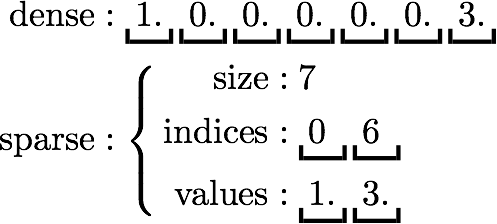

In [1]:
from IPython.display import Image
Image('/content/drive/My Drive/Colab Notebooks/08-apache-spark/images/vetores.png')

In [21]:
# Convert to a LabeledPoint (target, vector[features])
# Remove not relevant columns or with low correlation
def transform_var(row):
  obj = (row['MPG'], Vectors.dense([row['ACCELERATION'], row['DISPLACEMENT'], row['WEIGHT']]))
  return obj

In [24]:
# Use the RDD, apply a function, convert to a dataframe and apply a select() 
# function
cars_rdd4 = cars_rdd3.map(transform_var)
cars_df = sp_session.createDataFrame(cars_rdd4,['label','features'])
cars_df.select('label','features').show(10)

+-----+-------------------+
|label|           features|
+-----+-------------------+
| 18.0|[12.0,307.0,3504.0]|
| 15.0|[11.5,350.0,3693.0]|
| 18.0|[11.0,318.0,3436.0]|
| 16.0|[12.0,304.0,3433.0]|
| 17.0|[10.5,302.0,3449.0]|
| 15.0|[10.0,429.0,4341.0]|
| 14.0| [9.0,454.0,4354.0]|
| 14.0| [8.5,440.0,4312.0]|
| 14.0|[10.0,455.0,4425.0]|
| 15.0| [8.5,390.0,3850.0]|
+-----+-------------------+
only showing top 10 rows



# Machine Learning